# Audio reconstruction with context encoder

*   Original data and corrupted data (waveforms)
*   Original data and corrupted data (melspectrogram)

*   Original data, corrupted data, missing part (melspectrogram), reconstructed part (melspectrogram)
*   corrupted data (melspectrogram) + reconstructed part (melspectrogram) -> waveform (mel_to_audio)






In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
import random 
import copy
from numpy import savez_compressed, load
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Activation, Dense
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from sklearn.model_selection import train_test_split

# Loading data

In [ ]:
# load dict of arrays
dict_data = load("/content/gdrive/MyDrive/UrbanSound8K/dati/dataset8kHz.npz")
# extract the first array
data = dict_data['arr_0']
# label for each file, corresponding to the class
labels = pd.read_csv("/content/gdrive/MyDrive/UrbanSound8K/dati/all_labels.csv")
labels = labels['0']
metadata = pd.read_csv("/content/gdrive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv")
classes=np.unique(metadata["class"])
mapping=classes.tolist() 

In [ ]:
data = data.reshape(-1,32000,1)

In [ ]:
import librosa
import librosa.display

In [ ]:
import matplotlib.pyplot as plt

def plot_spectrogram(X):
  sr=8000
  fig, ax = plt.subplots()
  S_dB = librosa.power_to_db(X, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax)
  fig.colorbar(img, ax=ax, format='%+2.0f dB')
  ax.set(title='Mel-frequency spectrogram')

In [ ]:
x = data[6, :]
x_corr = copy.deepcopy(x)
x_corr[0:8000]=0
x_missing = data[6, 0:8000]

In [ ]:
print("Waveform shape: ", x.shape)
print("Corruption shape: ", x_missing.shape)
print("Waveform shape after reshape(-1): ", x.reshape(-1).shape)
print("Corruption shape after reshape(-1): ", x_missing.reshape(-1).shape)

Waveform shape:  (32000, 1)
Corruption shape:  (8000, 1)
Waveform shape after reshape(-1):  (32000,)
Corruption shape after reshape(-1):  (8000,)


In [ ]:
x_mel = librosa.feature.melspectrogram(y=x.reshape(-1), sr=8000)
x_corr_mel = librosa.feature.melspectrogram(y=x_corr.reshape(-1), sr=8000)
x_missing_mel = librosa.feature.melspectrogram(y=x_missing.reshape(-1), sr=8000)
x_recon = copy.deepcopy(x_corr_mel)
x_recon[:, 0:16]=x_missing_mel

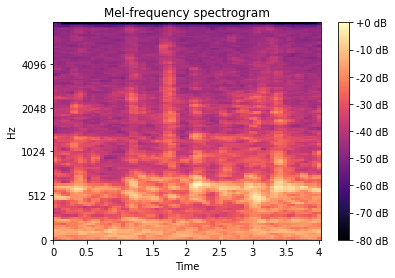

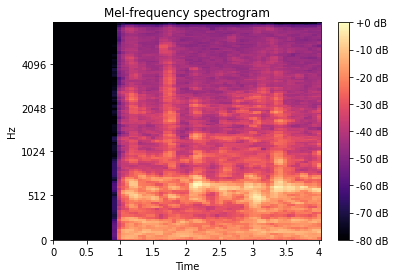

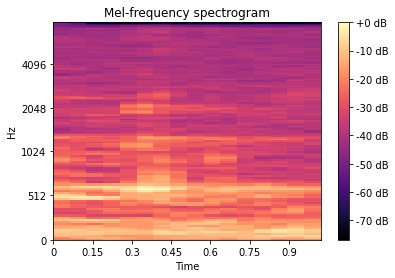

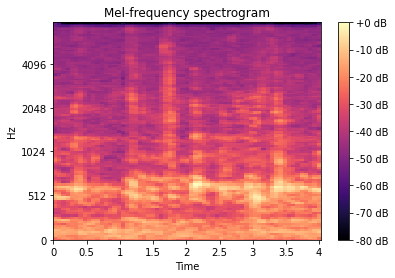

In [ ]:
plot_spectrogram(x_mel) # mel spectrogram 
plot_spectrogram(x_corr_mel) # mel spectrogram corrotto 
plot_spectrogram(x_missing_mel) # missing part 
plot_spectrogram(x_recon) # reconstructed mel spectrogram 

In [ ]:
print("Melspectrogram shape: ", x_mel.shape)
print("Corrupted melspectrogram shape: ", x_corr_mel.shape)
print("Corruption shape (melspectrogram): ", x_missing_mel.shape) # (128,1) se la corruzione è di 500; (128, 16) se la corruzione è di 8000
print("Reconstructed melspectrogram shape: ", x_recon.shape)

Melspectrogram shape:  (128, 63)
Corrupted melspectrogram shape:  (128, 63)
Corruption shape (melspectrogram):  (128, 16)
Reconstructed melspectrogram shape:  (128, 63)


In [ ]:
inverse_missing_part = librosa.feature.inverse.mel_to_audio(x_missing_mel, sr=8000)

In [ ]:
inverse_missing_part.shape

(7680,)

In [ ]:
inverse = librosa.feature.inverse.mel_to_audio(x_recon, sr=8000) 

In [ ]:
inverse.shape

(31744,)

**Waveform originale**

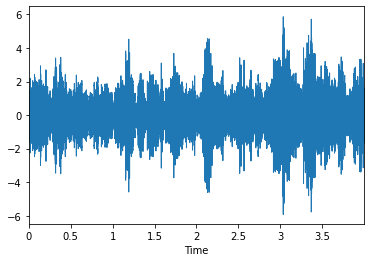

In [ ]:
librosa.display.waveplot(x.reshape(-1), sr=8000)

**Waveform corrotta**

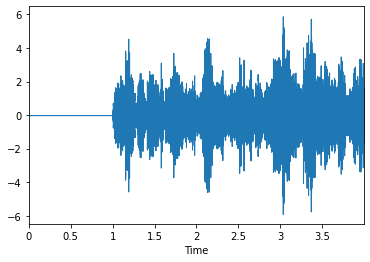

In [ ]:
librosa.display.waveplot(x_corr.reshape(-1), sr=8000)

**Waveform ricostruita**

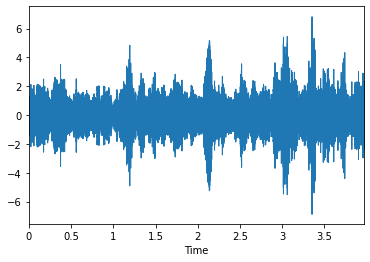

In [ ]:
librosa.display.waveplot(inverse, sr=8000)

In [ ]:
def corrupt_data(fold, width, multiple_fragments=False):
  if multiple_fragments:
    corrupt_data_multiple_fragments(fold,width)
  else:
    for sample in fold: 
      rand1 = random.randint(0, int(len(sample)/1.3)) #24000 
      sample[rand1:rand1+width] = 0 
      zeros = np.zeros(shape=sample[rand1:].shape)
      if (sample[rand1:]==zeros).all() == True:
          rand1 = random.randint(0, int(len(sample)/6)) # 5000 
          sample[rand1:rand1+width] = 0
  return fold
  
def corrupt_data_multiple_fragments(fold,width):
  for sample in fold:
    # corruption divided into 4 fragments
    rand1 = random.randint(0, int(len(sample)/12))
    rand2 = random.randint(int(len(sample)/6.5), int(len(sample)/4.5))
    rand3 = random.randint(int(len(sample)/3.5), int(len(sample)/2.5))
    rand4 = random.randint(int(len(sample)/2), int(len(sample)/1.1))
    rands = [rand1, rand2, rand3, rand4]
    for rand in rands:    
        sample[rand:rand+int(width/4)] = 0 
  return fold 

In [ ]:
x = np.random.rand(64, 32000, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler((-1, 1))
x_scaled = mms.fit_transform(x.reshape(-1, 32000)).reshape(x.shape)

In [ ]:
x_mel = librosa.feature.melspectrogram(y=x[1].reshape(-1), sr=8000)

In [ ]:
x_scaled_mel = librosa.feature.melspectrogram(y=x_scaled[1].reshape(-1), sr=8000)

In [ ]:
x_scaled_mel.shape

(128, 63)

In [ ]:
np.min(x_mel), np.max(x_mel)

(1.5060957508528499, 955.3373267376496)

In [ ]:
np.min(x_scaled_mel), np.max(x_scaled_mel)

(6.424475381357519, 299.5005683491567)

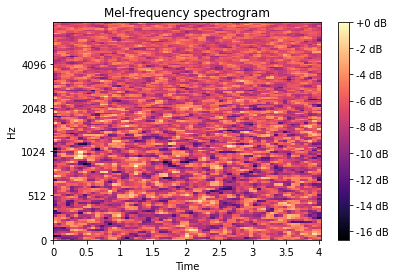

In [ ]:
plot_spectrogram(x_scaled_mel)

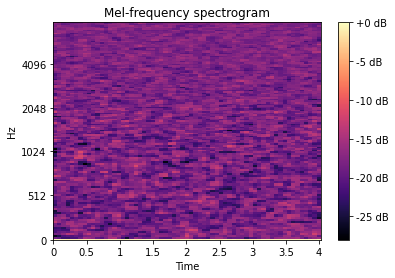

In [ ]:
plot_spectrogram(x_mel)

In [ ]:
x_inv = librosa.feature.inverse.mel_to_audio(x_mel, sr=8000)
x_inv_scal = librosa.feature.inverse.mel_to_audio(x_scaled_mel, sr=8000)

In [ ]:
np.min(x_inv), np.max(x_inv)

(-1.3112708, 1.376331)

In [ ]:
np.min(x_inv_scal), np.max(x_inv_scal)

(-2.535181, 2.5270267)

# GAN Context Encoder

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 8, 64)         640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 8, 64)         0         
                                                                 
 batch_normalization (BatchN  (None, 64, 8, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 4, 128)        73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 4, 128)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 4, 128)       512       
 hNormalization)                                        

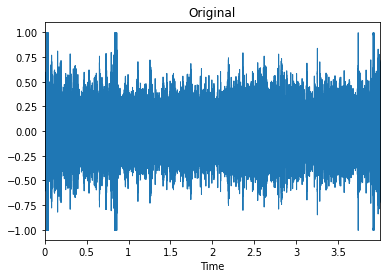

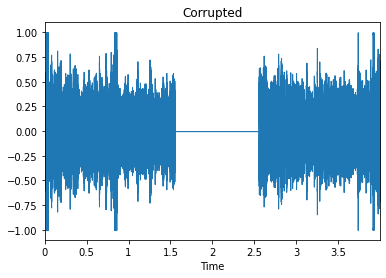

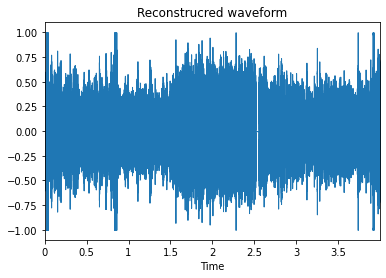


**************************************************


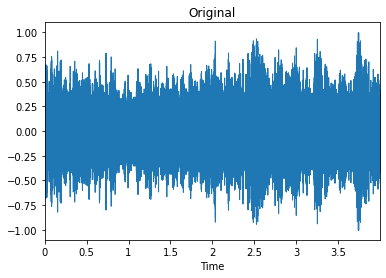

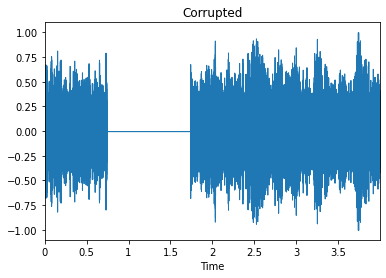

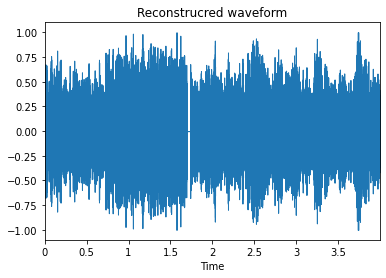


**************************************************


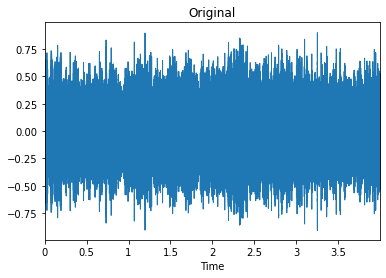

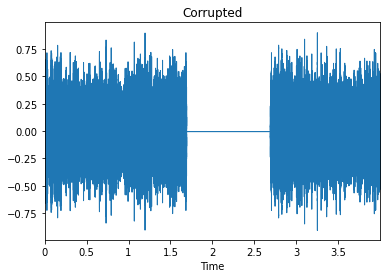

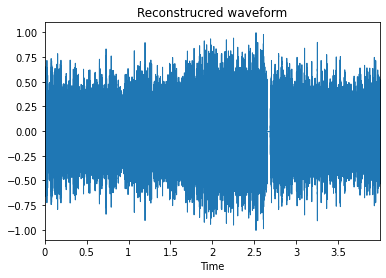


**************************************************
1 [D loss: 0.446397, acc: 99.22%] [G loss: 1207.851562, mse: 1209.060547]
2 [D loss: 0.632067, acc: 99.22%] [G loss: 1914.092529, mse: 1915.925293]
3 [D loss: 0.000223, acc: 100.00%] [G loss: 1509.324219, mse: 1510.762817]
4 [D loss: 74.620891, acc: 51.56%] [G loss: 1439.845581, mse: 1441.218750]
5 [D loss: 187.525135, acc: 0.78%] [G loss: 1249.076416, mse: 1250.326172]
6 [D loss: 232.031769, acc: 52.34%] [G loss: 1102.410278, mse: 1103.168091]
7 [D loss: 145.689388, acc: 27.34%] [G loss: 1152.364746, mse: 1153.516113]
8 [D loss: 6.370298, acc: 94.53%] [G loss: 739.627869, mse: 740.337402]
9 [D loss: 18.146506, acc: 80.47%] [G loss: 1625.616699, mse: 1627.243774]
10 [D loss: 1.349365, acc: 96.88%] [G loss: 1568.417725, mse: 1569.987671]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


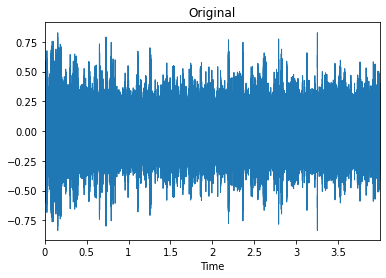

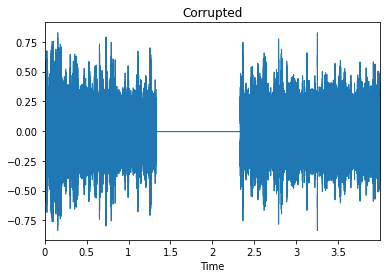

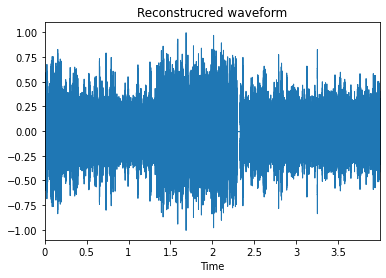


**************************************************


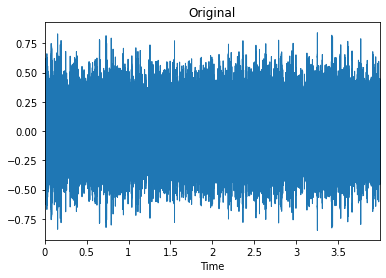

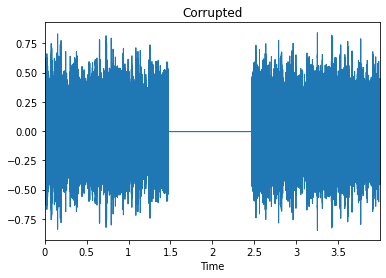

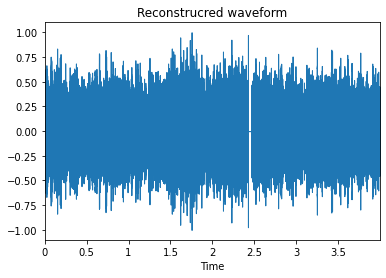


**************************************************


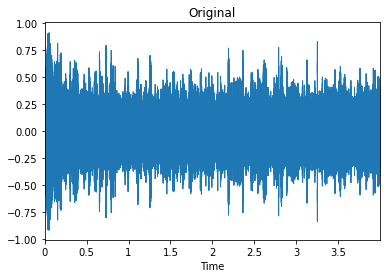

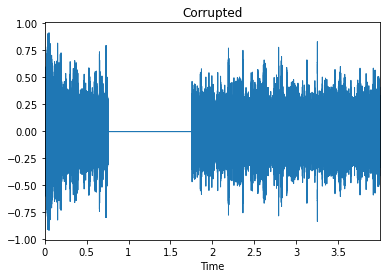

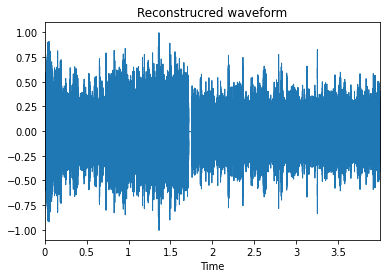


**************************************************
11 [D loss: 87.804855, acc: 51.56%] [G loss: 1126.515503, mse: 1127.587524]
12 [D loss: 38.332150, acc: 69.53%] [G loss: 1125.058228, mse: 1126.184448]
13 [D loss: 3.780937, acc: 94.53%] [G loss: 1464.583252, mse: 1466.049316]
14 [D loss: 0.833328, acc: 99.22%] [G loss: 1101.421021, mse: 1102.523560]
15 [D loss: 0.312684, acc: 99.22%] [G loss: 1505.045044, mse: 1506.551636]
16 [D loss: 0.071438, acc: 99.22%] [G loss: 1276.955688, mse: 1278.233765]
17 [D loss: 0.001408, acc: 100.00%] [G loss: 1527.919312, mse: 1529.448730]
18 [D loss: 0.262223, acc: 99.22%] [G loss: 1134.236206, mse: 1135.371582]
19 [D loss: 0.000000, acc: 100.00%] [G loss: 1208.423584, mse: 1209.633179]
20 [D loss: 0.000000, acc: 100.00%] [G loss: 991.235046, mse: 992.227234]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


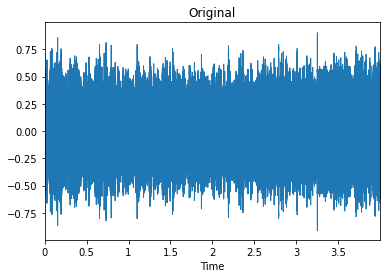

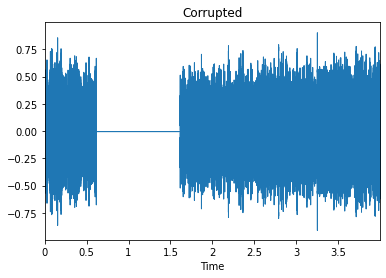

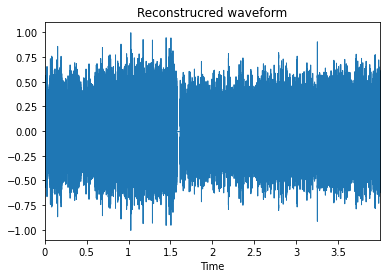


**************************************************


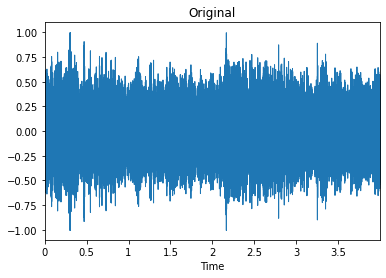

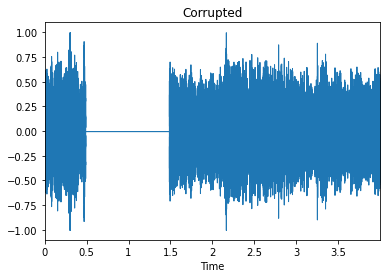

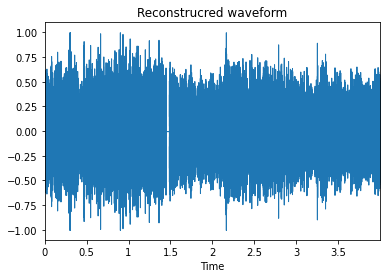


**************************************************


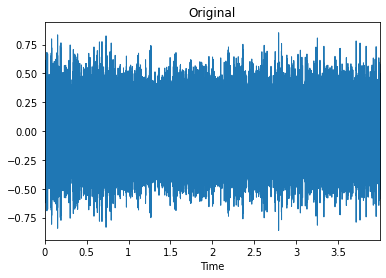

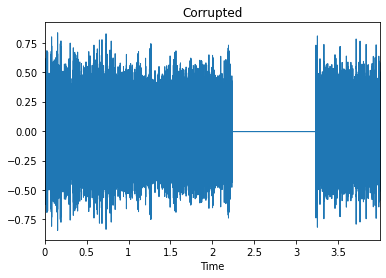

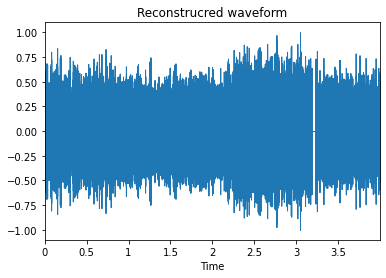


**************************************************
21 [D loss: 0.000000, acc: 100.00%] [G loss: 1391.711182, mse: 1393.104248]
22 [D loss: 0.000000, acc: 100.00%] [G loss: 1000.488525, mse: 1001.489990]
23 [D loss: 0.000000, acc: 100.00%] [G loss: 1635.762817, mse: 1637.400146]
24 [D loss: 0.001536, acc: 100.00%] [G loss: 1289.139771, mse: 1290.430176]
25 [D loss: 0.303010, acc: 99.22%] [G loss: 1127.219482, mse: 1128.347778]
26 [D loss: 0.494797, acc: 99.22%] [G loss: 1268.691284, mse: 1269.961182]
27 [D loss: 0.000040, acc: 100.00%] [G loss: 1711.502441, mse: 1713.215576]
28 [D loss: 0.000006, acc: 100.00%] [G loss: 819.321106, mse: 820.141235]
29 [D loss: 0.004445, acc: 100.00%] [G loss: 1698.623169, mse: 1700.323486]
30 [D loss: 0.000000, acc: 100.00%] [G loss: 1374.252075, mse: 1375.627686]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


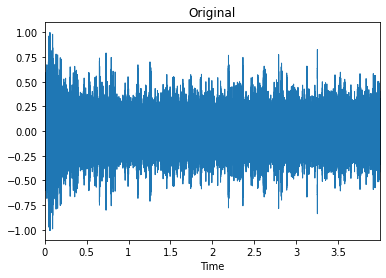

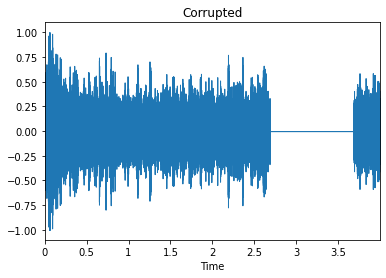

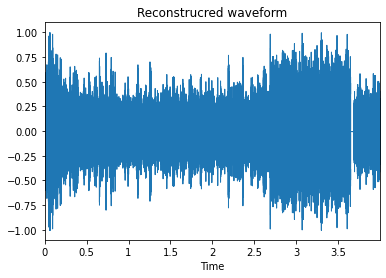


**************************************************


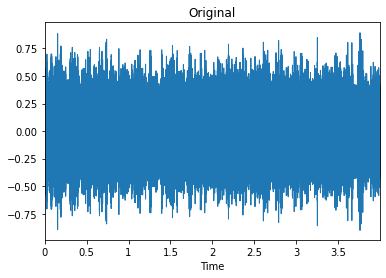

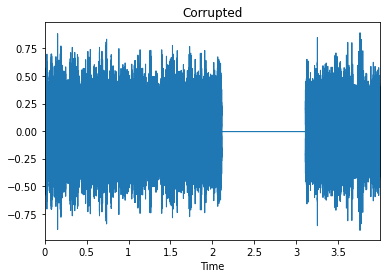

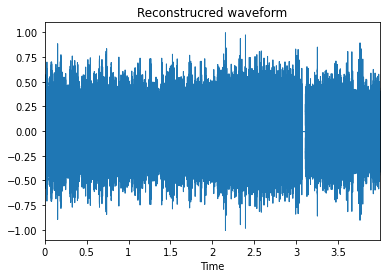


**************************************************


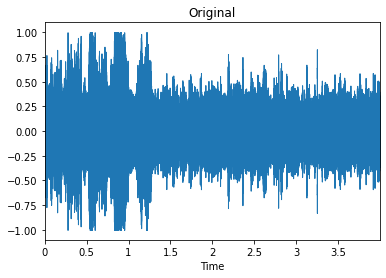

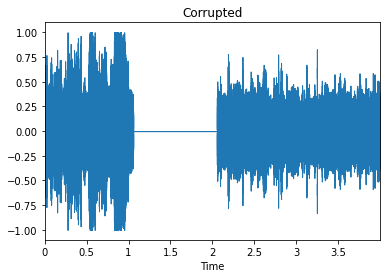

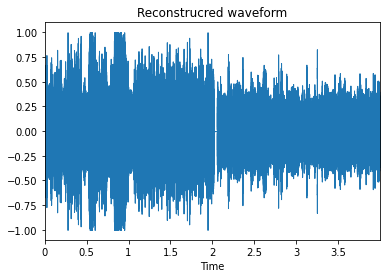


**************************************************
31 [D loss: 0.317852, acc: 99.22%] [G loss: 1386.638306, mse: 1388.026367]
32 [D loss: 0.000000, acc: 100.00%] [G loss: 955.407776, mse: 956.364136]
33 [D loss: 0.000000, acc: 100.00%] [G loss: 1102.594116, mse: 1103.697754]
34 [D loss: 0.000000, acc: 100.00%] [G loss: 1162.307861, mse: 1163.471313]
35 [D loss: 0.000000, acc: 100.00%] [G loss: 1295.218018, mse: 1296.514526]
36 [D loss: 0.000000, acc: 100.00%] [G loss: 1462.206543, mse: 1463.668457]
37 [D loss: 0.000000, acc: 100.00%] [G loss: 1200.876831, mse: 1202.072754]
38 [D loss: 0.000000, acc: 100.00%] [G loss: 1199.094727, mse: 1200.283936]
39 [D loss: 0.000000, acc: 100.00%] [G loss: 1095.052612, mse: 1096.134766]
40 [D loss: 0.000000, acc: 100.00%] [G loss: 1572.708252, mse: 1574.272949]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


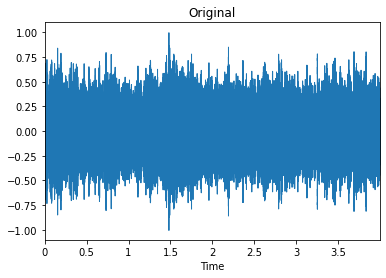

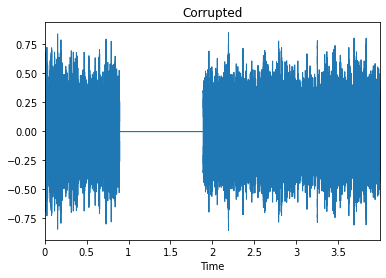

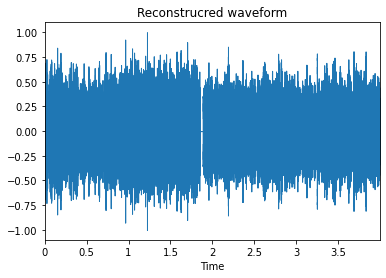


**************************************************


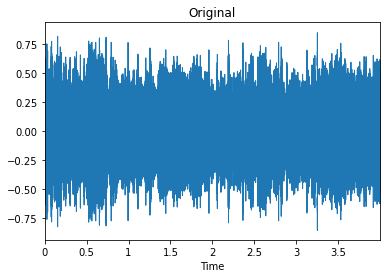

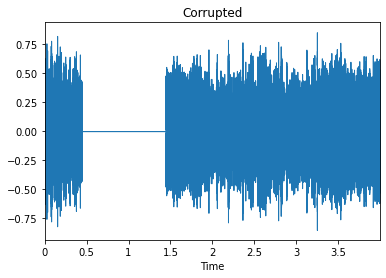

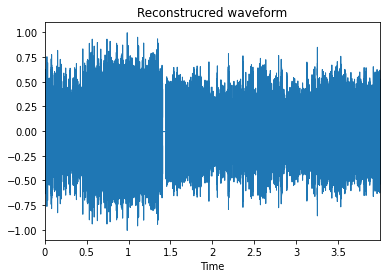


**************************************************


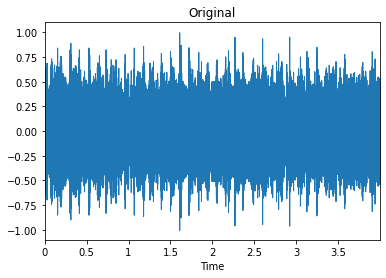

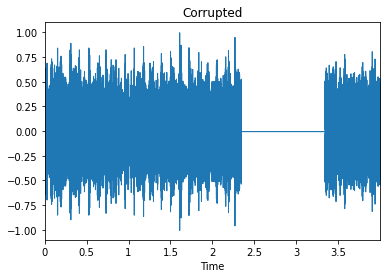

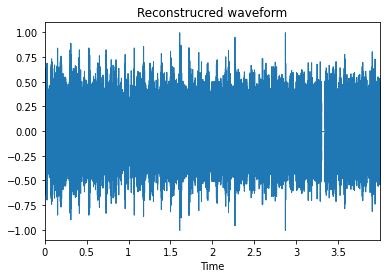


**************************************************
41 [D loss: 0.000000, acc: 100.00%] [G loss: 978.978149, mse: 979.948853]
42 [D loss: 0.000000, acc: 100.00%] [G loss: 1159.048706, mse: 1160.203613]
43 [D loss: 0.000000, acc: 100.00%] [G loss: 992.818481, mse: 993.810913]
44 [D loss: 0.000000, acc: 100.00%] [G loss: 2075.189453, mse: 2077.266602]
45 [D loss: 61.555893, acc: 58.59%] [G loss: 1285.476196, mse: 1286.705688]
46 [D loss: 55.382504, acc: 55.47%] [G loss: 1003.819946, mse: 1004.824768]
47 [D loss: 17.742244, acc: 88.28%] [G loss: 1298.675781, mse: 1299.975708]
48 [D loss: 0.000000, acc: 100.00%] [G loss: 827.633972, mse: 828.462402]
49 [D loss: 0.000000, acc: 100.00%] [G loss: 1258.756592, mse: 1260.016602]
50 [D loss: 0.000000, acc: 100.00%] [G loss: 1003.032837, mse: 1004.036865]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


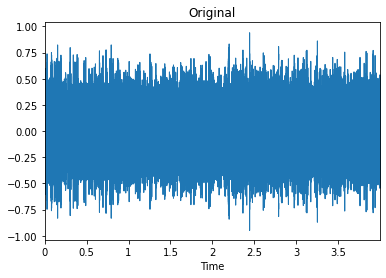

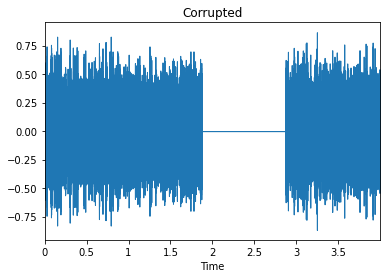

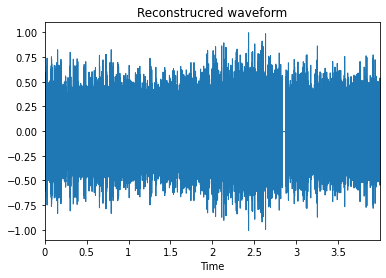


**************************************************


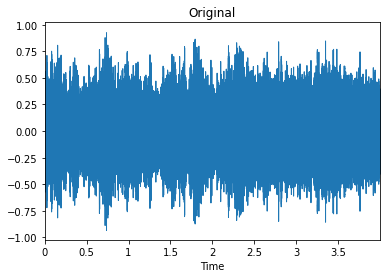

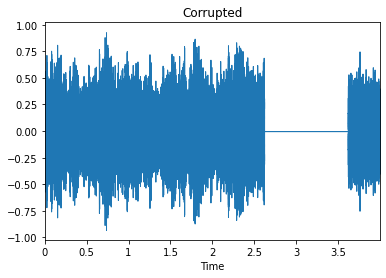

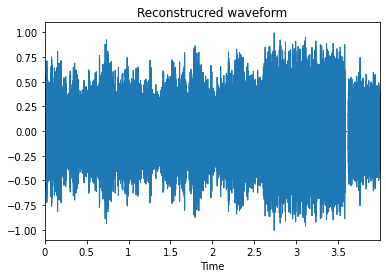


**************************************************


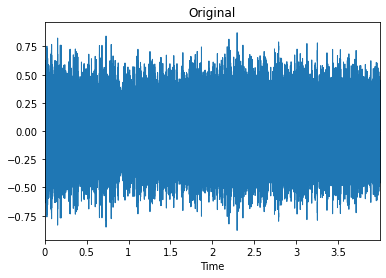

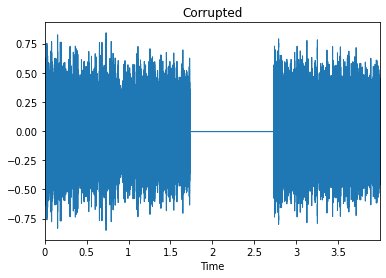

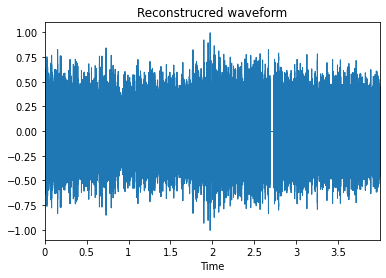


**************************************************
51 [D loss: 109.868011, acc: 50.00%] [G loss: 1018.681885, mse: 1019.701599]
52 [D loss: 30.036575, acc: 82.03%] [G loss: 1708.850220, mse: 1710.560791]
53 [D loss: 3.560594, acc: 96.09%] [G loss: 1443.115967, mse: 1444.547852]
54 [D loss: 6.463012, acc: 97.66%] [G loss: 1344.053711, mse: 1345.364258]
55 [D loss: 0.000000, acc: 100.00%] [G loss: 1096.706543, mse: 1097.766724]
56 [D loss: 0.000000, acc: 100.00%] [G loss: 1190.555542, mse: 1191.712524]
57 [D loss: 0.831964, acc: 99.22%] [G loss: 1550.518311, mse: 1552.042114]
58 [D loss: 0.000000, acc: 100.00%] [G loss: 1167.866211, mse: 1169.011230]
59 [D loss: 0.000000, acc: 100.00%] [G loss: 962.175720, mse: 963.115601]
60 [D loss: 2.110277, acc: 99.22%] [G loss: 1717.046021, mse: 1718.737915]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


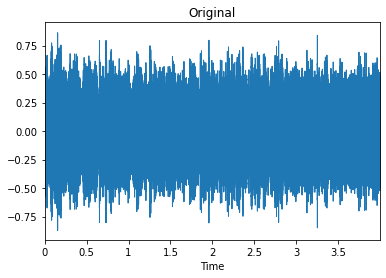

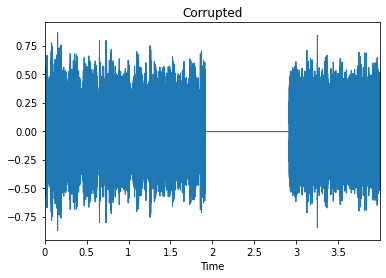

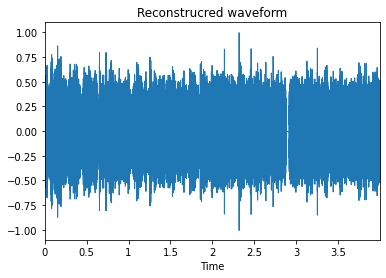


**************************************************


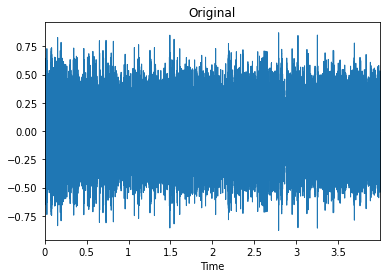

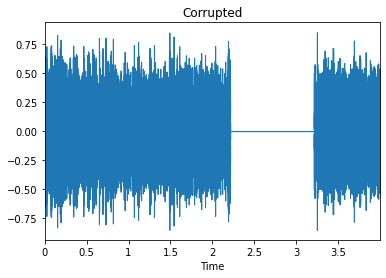

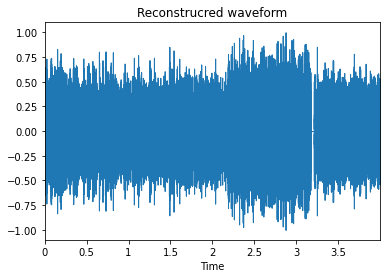


**************************************************


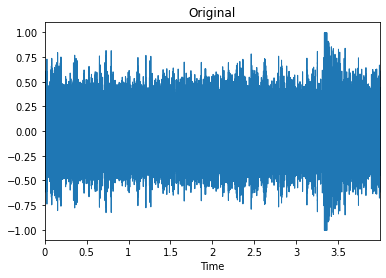

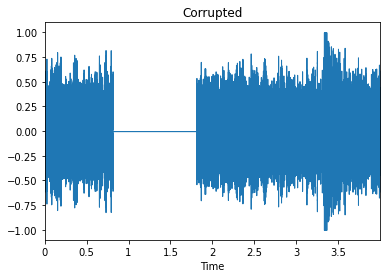

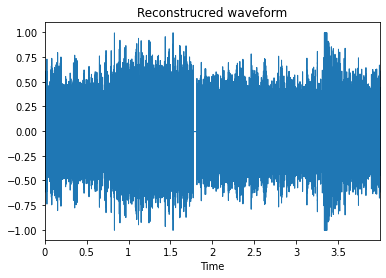


**************************************************
61 [D loss: 1.982496, acc: 98.44%] [G loss: 1380.504639, mse: 1381.848755]
62 [D loss: 0.000000, acc: 100.00%] [G loss: 1170.850830, mse: 1171.978516]
63 [D loss: 0.000000, acc: 100.00%] [G loss: 1085.130737, mse: 1086.170288]
64 [D loss: 0.000000, acc: 100.00%] [G loss: 1625.554199, mse: 1627.134521]
65 [D loss: 0.000000, acc: 100.00%] [G loss: 1297.444214, mse: 1298.697510]
66 [D loss: 0.000000, acc: 100.00%] [G loss: 1577.942017, mse: 1579.475830]
67 [D loss: 0.000000, acc: 100.00%] [G loss: 1222.228516, mse: 1223.405029]
68 [D loss: 0.000000, acc: 100.00%] [G loss: 1353.961426, mse: 1355.267822]
69 [D loss: 0.000000, acc: 100.00%] [G loss: 1529.660767, mse: 1531.142822]
70 [D loss: 0.000000, acc: 100.00%] [G loss: 1005.990906, mse: 1006.946899]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


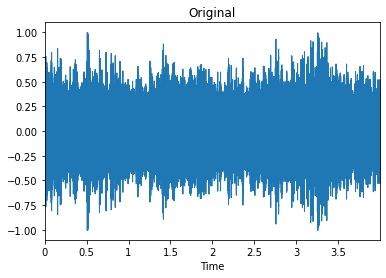

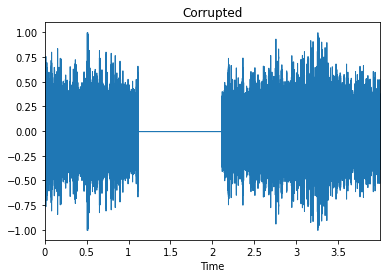

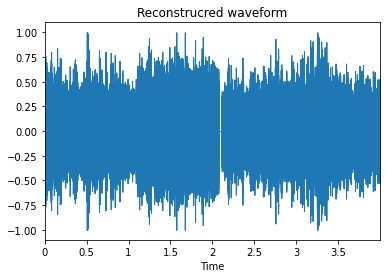


**************************************************


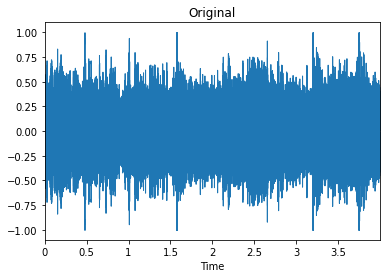

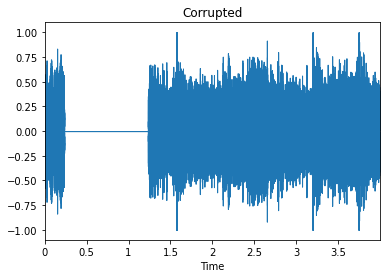

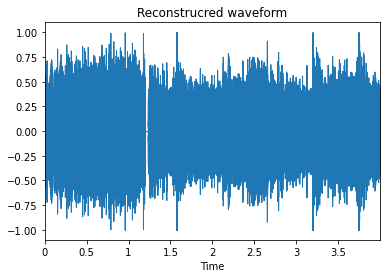


**************************************************


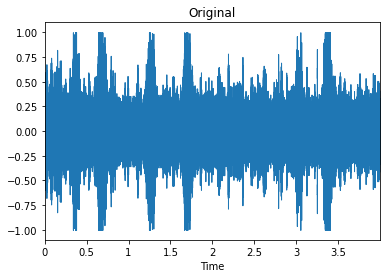

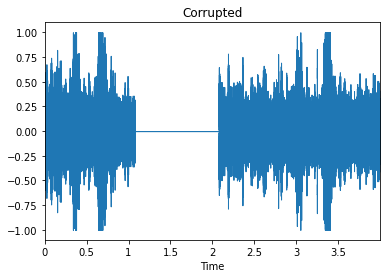

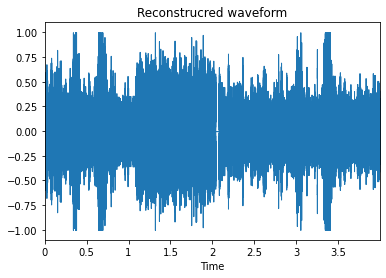


**************************************************
71 [D loss: 0.000000, acc: 100.00%] [G loss: 1013.443176, mse: 1014.406006]
72 [D loss: 0.000000, acc: 100.00%] [G loss: 1364.505981, mse: 1365.824463]
73 [D loss: 0.000000, acc: 100.00%] [G loss: 1691.337891, mse: 1692.983398]
74 [D loss: 0.000000, acc: 100.00%] [G loss: 1343.864624, mse: 1345.162109]
75 [D loss: 0.000000, acc: 100.00%] [G loss: 1255.014648, mse: 1256.222900]
76 [D loss: 0.000000, acc: 100.00%] [G loss: 1675.729126, mse: 1677.361084]
77 [D loss: 0.000000, acc: 100.00%] [G loss: 1318.022705, mse: 1319.300781]
78 [D loss: 0.000000, acc: 100.00%] [G loss: 1618.495972, mse: 1620.073608]
79 [D loss: 1.298058, acc: 98.44%] [G loss: 1673.007568, mse: 1674.649048]
80 [D loss: 0.000000, acc: 100.00%] [G loss: 1214.348267, mse: 1215.530029]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


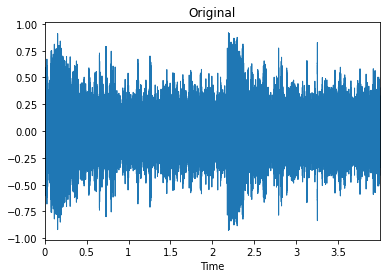

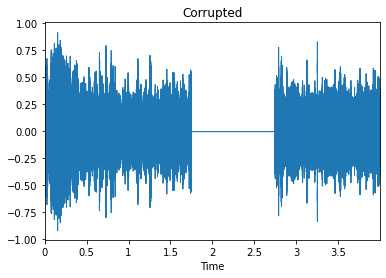

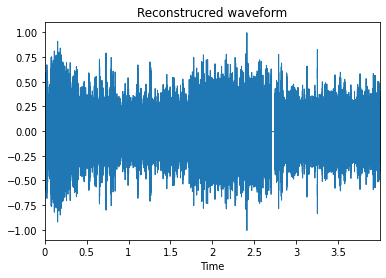


**************************************************


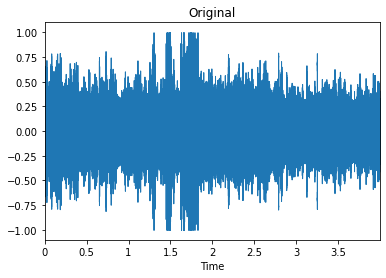

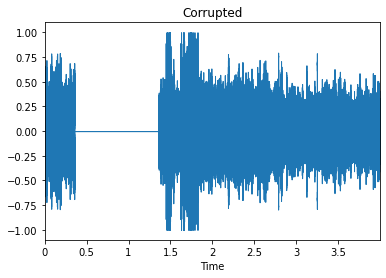

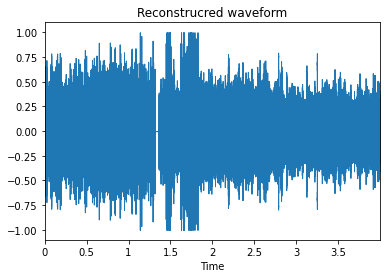


**************************************************


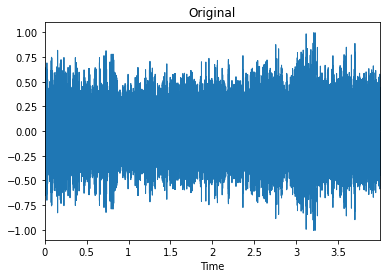

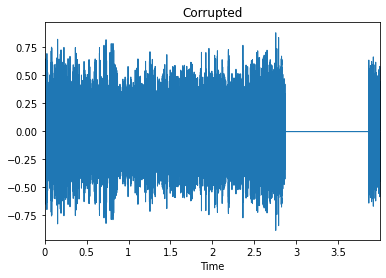

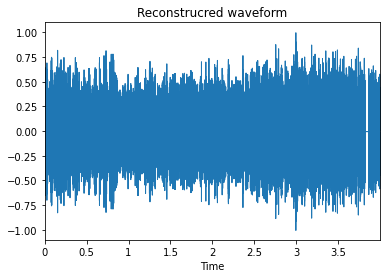


**************************************************
81 [D loss: 0.000000, acc: 100.00%] [G loss: 1125.800659, mse: 1126.892334]
82 [D loss: 0.000000, acc: 100.00%] [G loss: 1376.356079, mse: 1377.698486]
83 [D loss: 0.000000, acc: 100.00%] [G loss: 977.315735, mse: 978.254150]
84 [D loss: 0.000000, acc: 100.00%] [G loss: 1538.516357, mse: 1540.019287]
85 [D loss: 0.405394, acc: 99.22%] [G loss: 1105.852905, mse: 1106.925049]
86 [D loss: 0.000000, acc: 100.00%] [G loss: 2035.053223, mse: 2037.057861]
87 [D loss: 0.000000, acc: 100.00%] [G loss: 1048.583008, mse: 1049.598511]
88 [D loss: 0.000000, acc: 100.00%] [G loss: 1146.702148, mse: 1147.813599]
89 [D loss: 0.000000, acc: 100.00%] [G loss: 958.007874, mse: 958.925903]
90 [D loss: 0.000000, acc: 100.00%] [G loss: 1190.636719, mse: 1191.788330]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


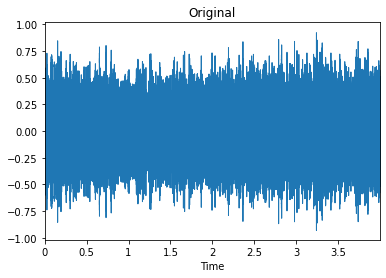

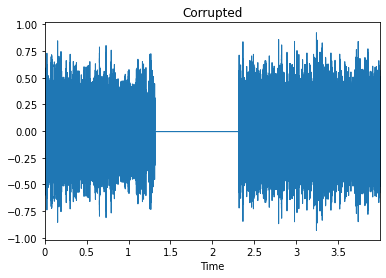

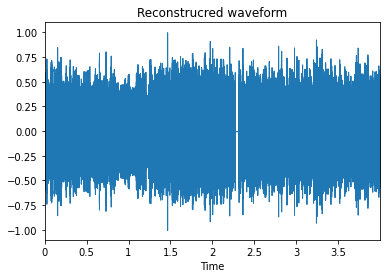


**************************************************


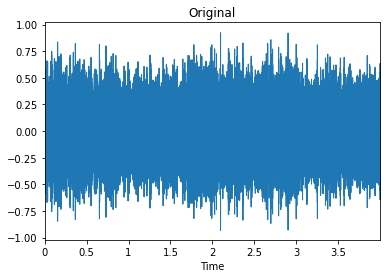

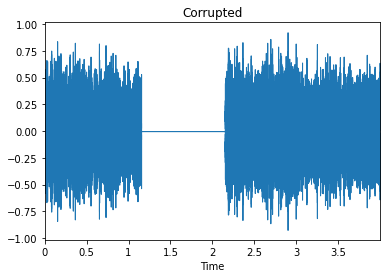

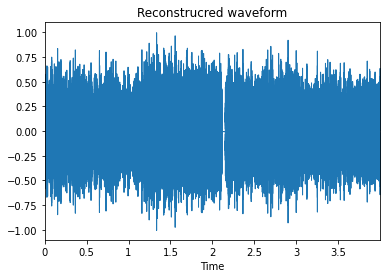


**************************************************


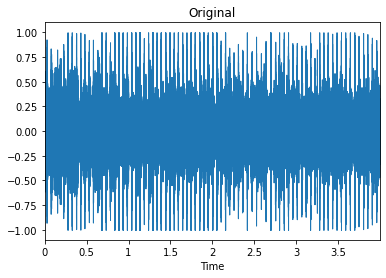

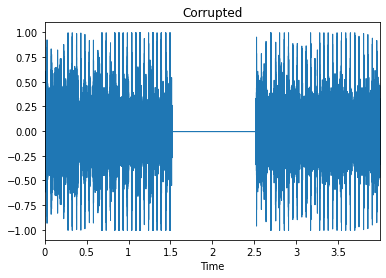

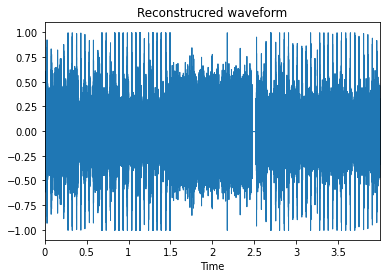


**************************************************
91 [D loss: 0.000000, acc: 100.00%] [G loss: 1527.089233, mse: 1528.575684]
92 [D loss: 0.000000, acc: 100.00%] [G loss: 1415.715088, mse: 1417.090332]
93 [D loss: 0.000000, acc: 100.00%] [G loss: 895.303223, mse: 896.155762]
94 [D loss: 0.000000, acc: 100.00%] [G loss: 1334.328003, mse: 1335.621948]
95 [D loss: 0.000000, acc: 100.00%] [G loss: 1136.068848, mse: 1137.165039]
96 [D loss: 0.000000, acc: 100.00%] [G loss: 1325.874268, mse: 1327.160889]
97 [D loss: 0.000000, acc: 100.00%] [G loss: 1128.672607, mse: 1129.761719]
98 [D loss: 0.000000, acc: 100.00%] [G loss: 1246.475220, mse: 1247.682983]
99 [D loss: 0.000000, acc: 100.00%] [G loss: 1672.973022, mse: 1674.612549]
100 [D loss: 0.000000, acc: 100.00%] [G loss: 1400.645142, mse: 1402.010376]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


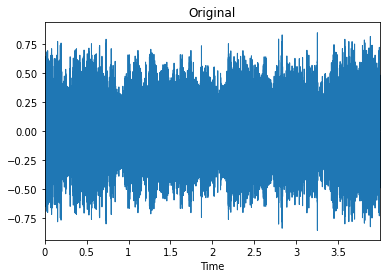

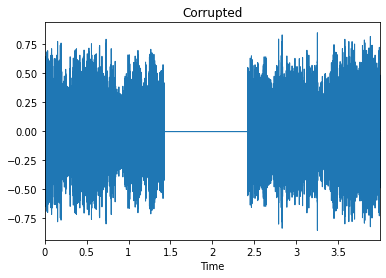

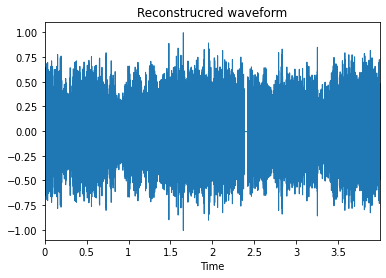


**************************************************


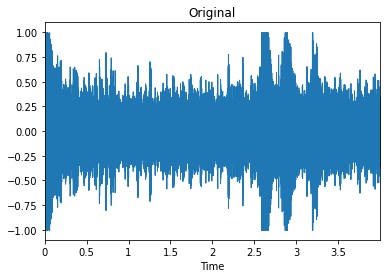

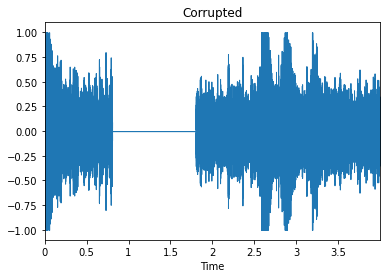

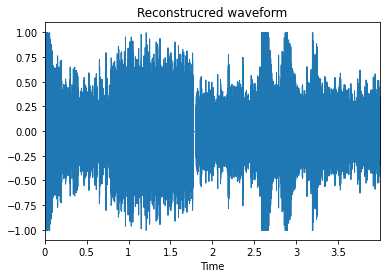


**************************************************


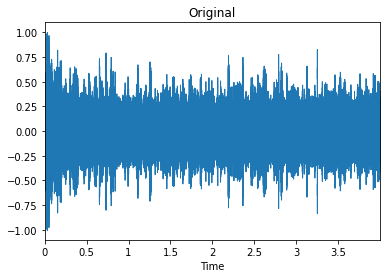

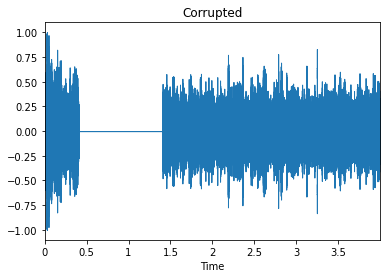

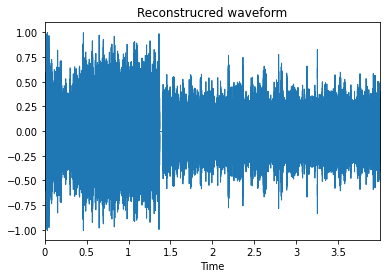


**************************************************
101 [D loss: 0.000000, acc: 100.00%] [G loss: 1253.901367, mse: 1255.118652]
102 [D loss: 0.000000, acc: 100.00%] [G loss: 1309.392578, mse: 1310.666382]
103 [D loss: 0.000000, acc: 100.00%] [G loss: 1085.788940, mse: 1086.837402]
104 [D loss: 3.279939, acc: 99.22%] [G loss: 1922.572144, mse: 1924.457520]
105 [D loss: 0.000000, acc: 100.00%] [G loss: 1263.321167, mse: 1264.540039]
106 [D loss: 0.000000, acc: 100.00%] [G loss: 1008.836914, mse: 1009.794922]
107 [D loss: 0.000000, acc: 100.00%] [G loss: 1243.702637, mse: 1244.890137]
108 [D loss: 0.000000, acc: 100.00%] [G loss: 1230.500610, mse: 1231.676392]
109 [D loss: 0.000000, acc: 100.00%] [G loss: 1621.015381, mse: 1622.580811]
110 [D loss: 0.000000, acc: 100.00%] [G loss: 2586.649902, mse: 2589.183594]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


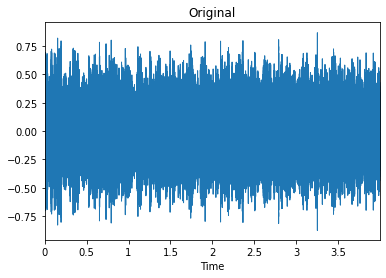

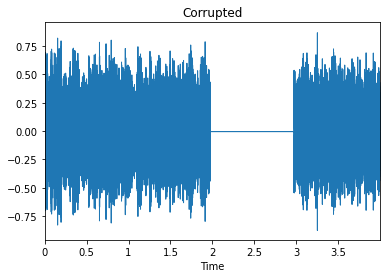

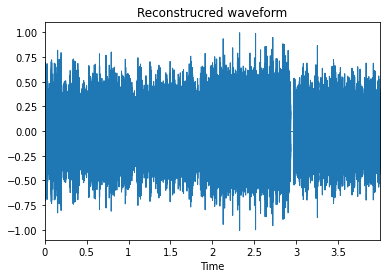


**************************************************


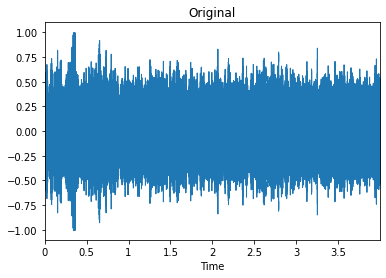

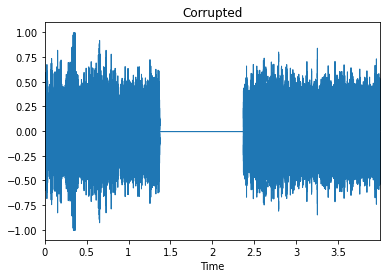

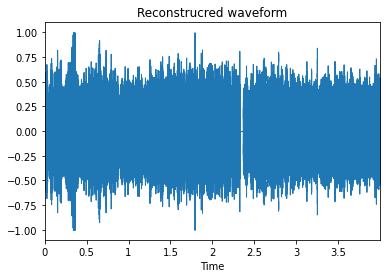


**************************************************


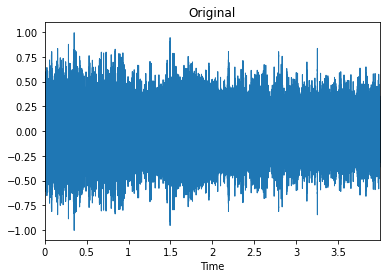

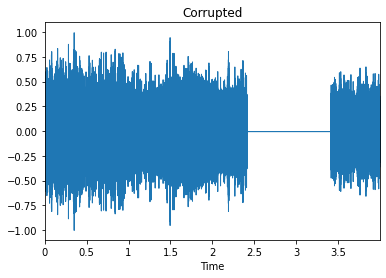

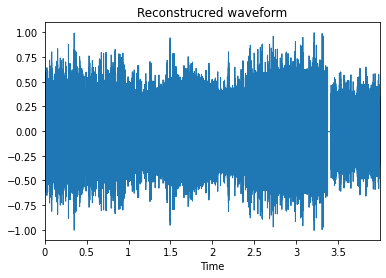


**************************************************
111 [D loss: 0.000000, acc: 100.00%] [G loss: 1218.193115, mse: 1219.356689]
112 [D loss: 0.000000, acc: 100.00%] [G loss: 828.128479, mse: 828.896729]
113 [D loss: 0.000000, acc: 100.00%] [G loss: 904.018799, mse: 904.863403]
114 [D loss: 0.000000, acc: 100.00%] [G loss: 903.308350, mse: 904.148499]
115 [D loss: 0.000000, acc: 100.00%] [G loss: 1998.205078, mse: 2000.147461]
116 [D loss: 0.000000, acc: 100.00%] [G loss: 1656.381104, mse: 1657.986084]
117 [D loss: 0.000000, acc: 100.00%] [G loss: 1411.063721, mse: 1412.421143]
118 [D loss: 0.000000, acc: 100.00%] [G loss: 946.941162, mse: 947.831299]
119 [D loss: 0.000000, acc: 100.00%] [G loss: 997.300171, mse: 998.234619]
120 [D loss: 0.000000, acc: 100.00%] [G loss: 1169.610352, mse: 1170.720947]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


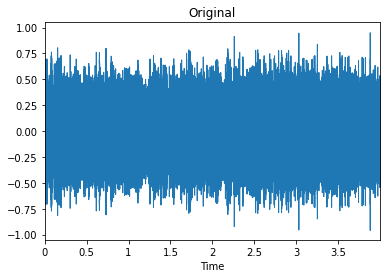

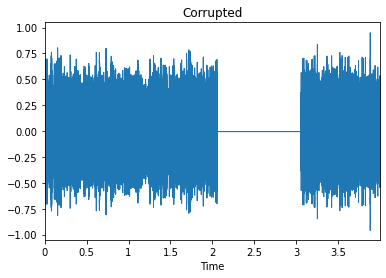

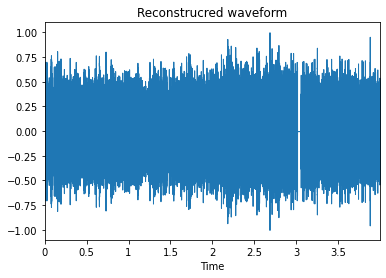


**************************************************


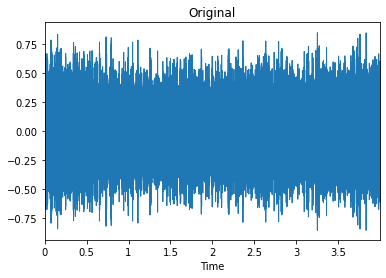

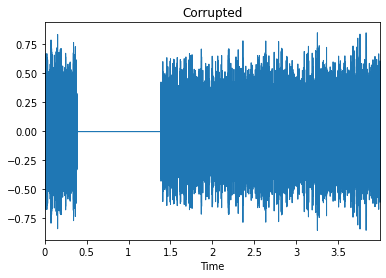

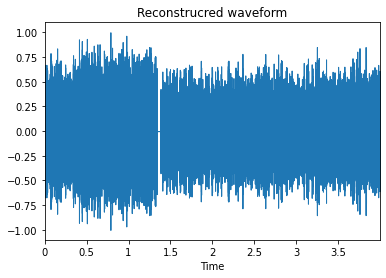


**************************************************


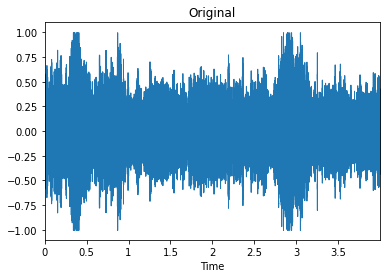

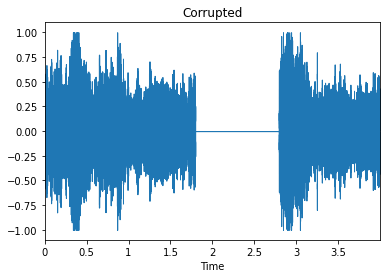

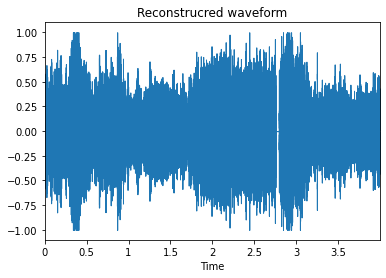


**************************************************
121 [D loss: 0.000000, acc: 100.00%] [G loss: 1329.516968, mse: 1330.789062]
122 [D loss: 0.000000, acc: 100.00%] [G loss: 1093.807617, mse: 1094.845459]
123 [D loss: 0.000000, acc: 100.00%] [G loss: 1596.989746, mse: 1598.533691]
124 [D loss: 0.000000, acc: 100.00%] [G loss: 1395.343750, mse: 1396.684570]
125 [D loss: 0.000000, acc: 100.00%] [G loss: 1103.893921, mse: 1104.940796]
126 [D loss: 0.000000, acc: 100.00%] [G loss: 1775.977295, mse: 1777.699463]
127 [D loss: 0.000000, acc: 100.00%] [G loss: 1189.388794, mse: 1190.520752]
128 [D loss: 0.000000, acc: 100.00%] [G loss: 1298.753174, mse: 1299.997070]
129 [D loss: 0.000000, acc: 100.00%] [G loss: 1012.325195, mse: 1013.280396]
130 [D loss: 0.000000, acc: 100.00%] [G loss: 1649.731201, mse: 1651.324463]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


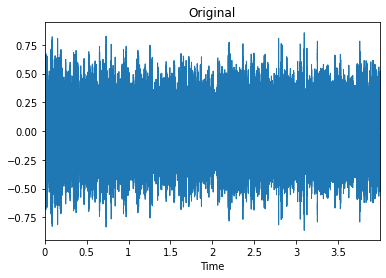

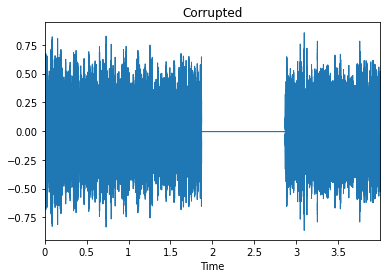

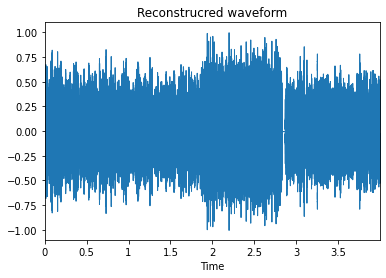


**************************************************


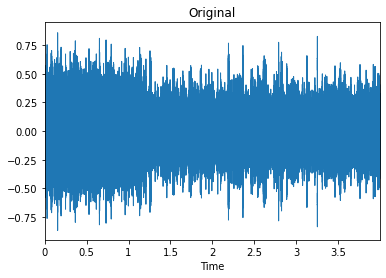

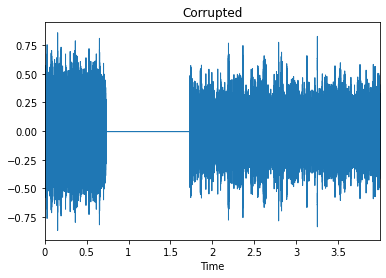

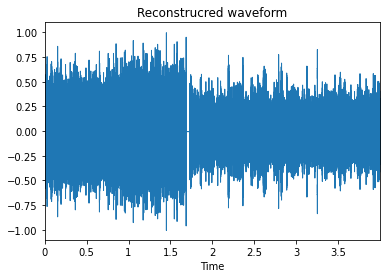


**************************************************


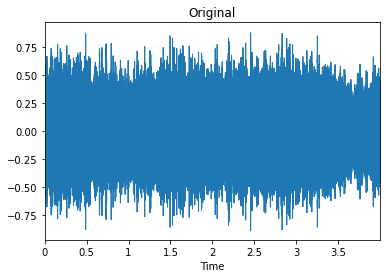

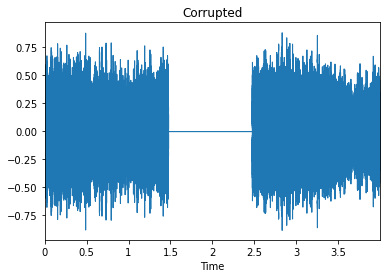

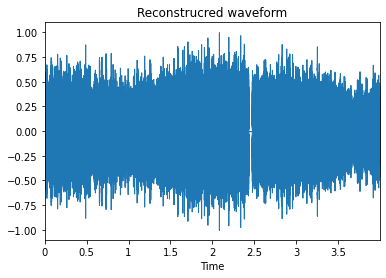


**************************************************
131 [D loss: 0.000000, acc: 100.00%] [G loss: 1199.112671, mse: 1200.256958]
132 [D loss: 0.000000, acc: 100.00%] [G loss: 1237.092163, mse: 1238.273315]
133 [D loss: 0.000000, acc: 100.00%] [G loss: 986.579407, mse: 987.506714]
134 [D loss: 0.000000, acc: 100.00%] [G loss: 1152.483643, mse: 1153.578857]
135 [D loss: 0.000000, acc: 100.00%] [G loss: 1198.424438, mse: 1199.565186]
136 [D loss: 0.000000, acc: 100.00%] [G loss: 958.576538, mse: 959.475708]
137 [D loss: 0.000000, acc: 100.00%] [G loss: 1356.222656, mse: 1357.519043]
138 [D loss: 0.000000, acc: 100.00%] [G loss: 1128.444458, mse: 1129.512573]
139 [D loss: 0.000000, acc: 100.00%] [G loss: 1072.677246, mse: 1073.688721]
140 [D loss: 0.000000, acc: 100.00%] [G loss: 1233.327393, mse: 1234.501831]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


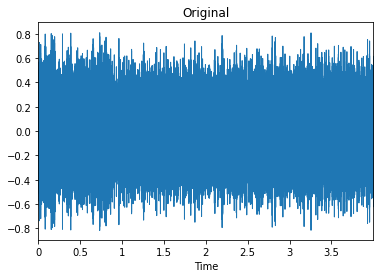

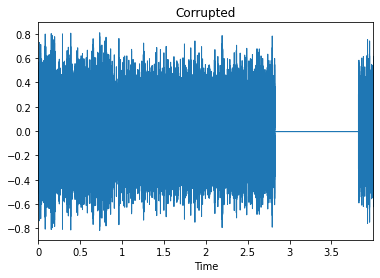

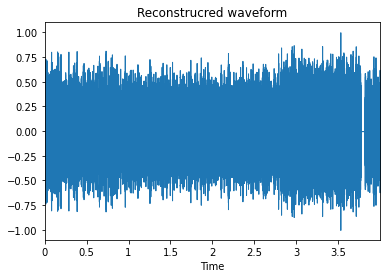


**************************************************


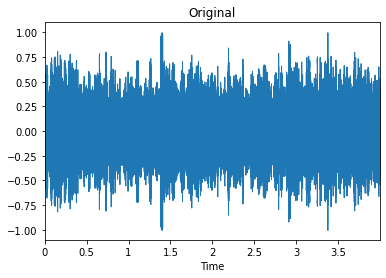

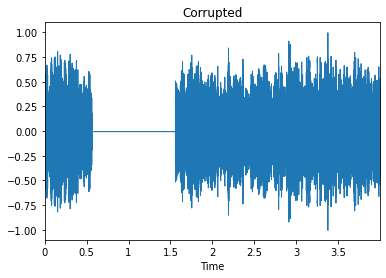

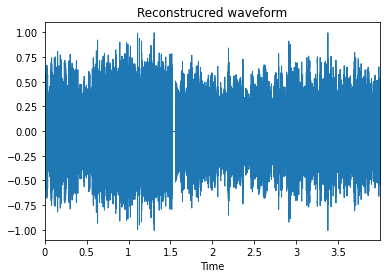


**************************************************


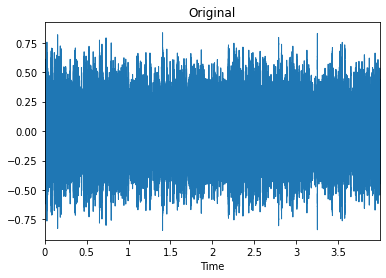

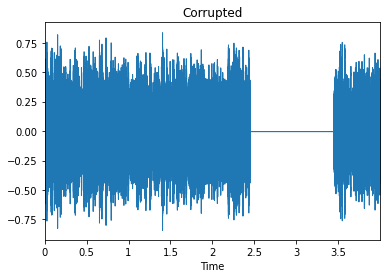

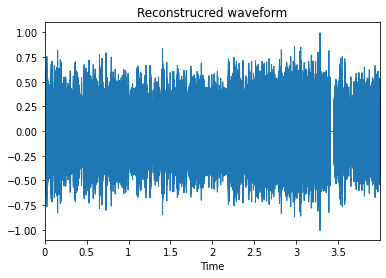


**************************************************
141 [D loss: 0.000000, acc: 100.00%] [G loss: 1049.938477, mse: 1050.930786]
142 [D loss: 0.000000, acc: 100.00%] [G loss: 942.911255, mse: 943.794189]
143 [D loss: 0.000000, acc: 100.00%] [G loss: 1022.091125, mse: 1023.055664]
144 [D loss: 0.000000, acc: 100.00%] [G loss: 1765.706055, mse: 1767.414917]
145 [D loss: 0.000000, acc: 100.00%] [G loss: 1837.815063, mse: 1839.595947]
146 [D loss: 0.421226, acc: 99.22%] [G loss: 1998.648438, mse: 2000.595703]
147 [D loss: 0.000000, acc: 100.00%] [G loss: 1275.200317, mse: 1276.420898]
148 [D loss: 0.000000, acc: 100.00%] [G loss: 1282.760620, mse: 1283.986572]
149 [D loss: 0.000000, acc: 100.00%] [G loss: 1090.753052, mse: 1091.782959]
150 [D loss: 0.000000, acc: 100.00%] [G loss: 1905.094482, mse: 1906.943237]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


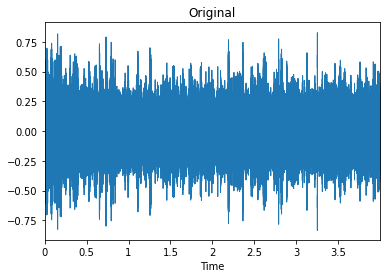

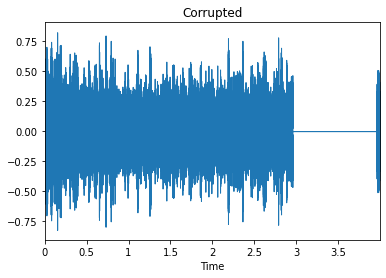

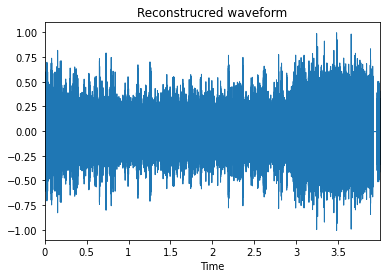


**************************************************


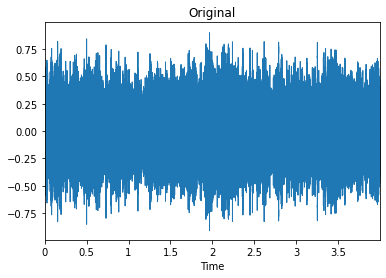

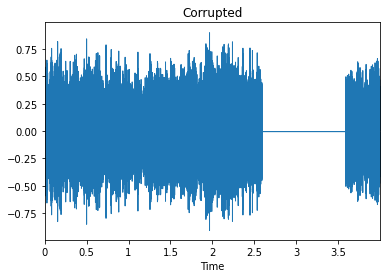

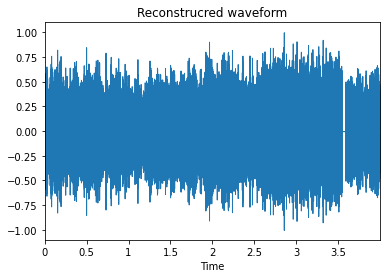


**************************************************


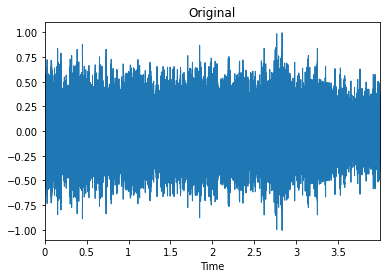

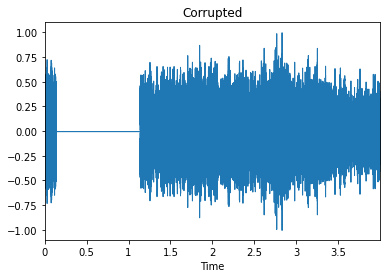

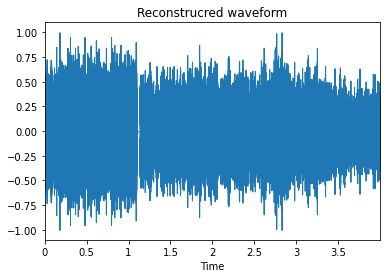


**************************************************
151 [D loss: 0.000000, acc: 100.00%] [G loss: 1289.412964, mse: 1290.645020]
152 [D loss: 0.000000, acc: 100.00%] [G loss: 1586.687744, mse: 1588.219971]
153 [D loss: 0.000000, acc: 100.00%] [G loss: 1442.898682, mse: 1444.287476]
154 [D loss: 0.000000, acc: 100.00%] [G loss: 1014.180176, mse: 1015.134705]
155 [D loss: 0.000000, acc: 100.00%] [G loss: 1358.506226, mse: 1359.804443]
156 [D loss: 0.000000, acc: 100.00%] [G loss: 1060.193115, mse: 1061.189941]
157 [D loss: 0.000000, acc: 100.00%] [G loss: 1160.583740, mse: 1161.677856]
158 [D loss: 0.000000, acc: 100.00%] [G loss: 923.279602, mse: 924.133423]
159 [D loss: 0.000000, acc: 100.00%] [G loss: 1011.856384, mse: 1012.800476]
160 [D loss: 0.000000, acc: 100.00%] [G loss: 948.674072, mse: 949.550781]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


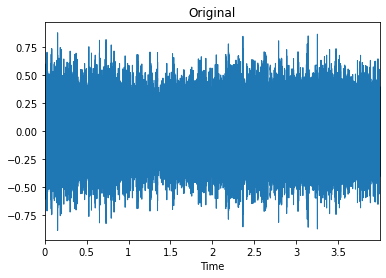

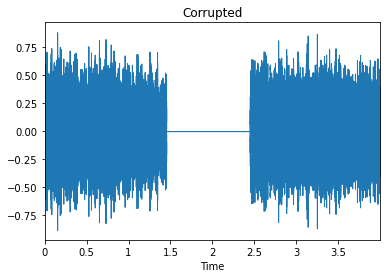

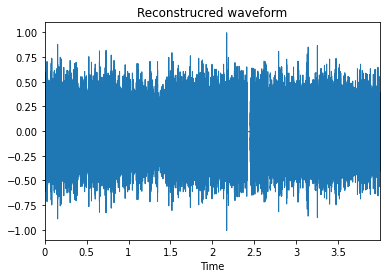


**************************************************


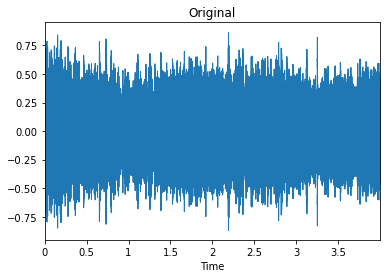

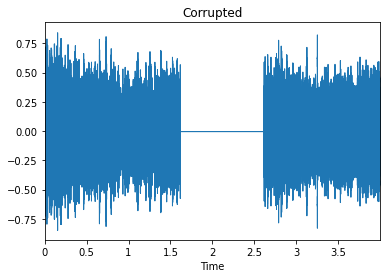

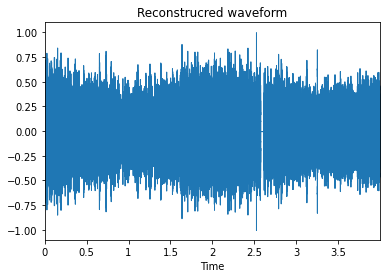


**************************************************


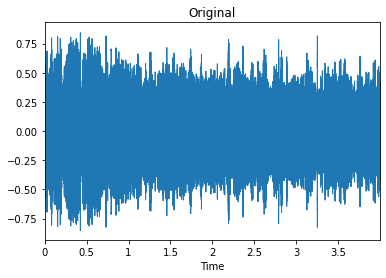

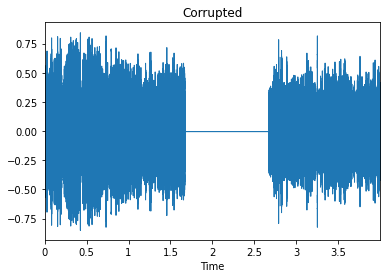

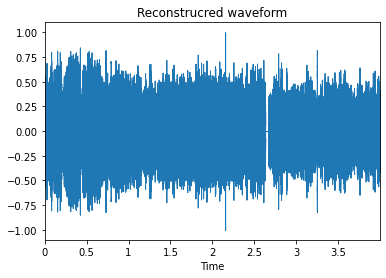


**************************************************
161 [D loss: 0.000000, acc: 100.00%] [G loss: 1327.214111, mse: 1328.469604]
162 [D loss: 0.000000, acc: 100.00%] [G loss: 1167.523682, mse: 1168.619385]
163 [D loss: 0.000000, acc: 100.00%] [G loss: 1094.184326, mse: 1095.206787]
164 [D loss: 0.000000, acc: 100.00%] [G loss: 1168.700684, mse: 1169.800415]
165 [D loss: 0.000000, acc: 100.00%] [G loss: 2309.229248, mse: 2311.481201]
166 [D loss: 0.000000, acc: 100.00%] [G loss: 2009.113647, mse: 2011.063110]
167 [D loss: 0.000000, acc: 100.00%] [G loss: 2341.276611, mse: 2343.562744]
168 [D loss: 0.000000, acc: 100.00%] [G loss: 1315.524414, mse: 1316.782227]
169 [D loss: 0.000000, acc: 100.00%] [G loss: 1473.996704, mse: 1475.407715]
170 [D loss: 0.000000, acc: 100.00%] [G loss: 923.049805, mse: 923.904541]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


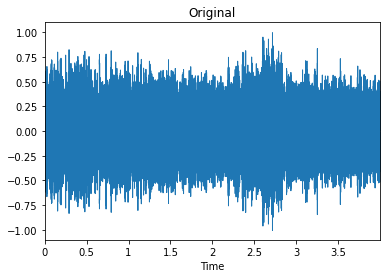

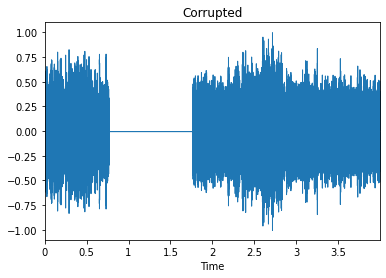

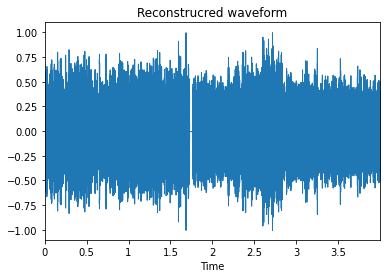


**************************************************


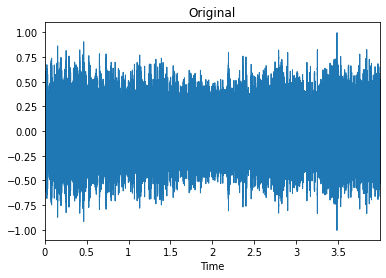

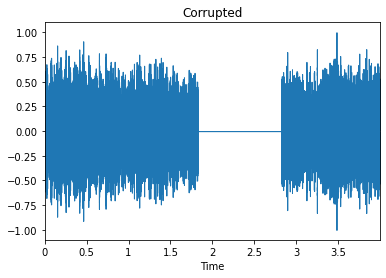

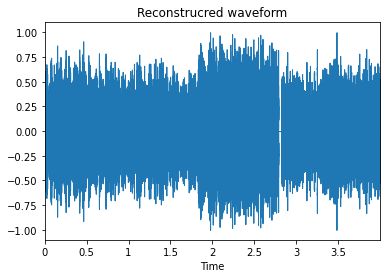


**************************************************


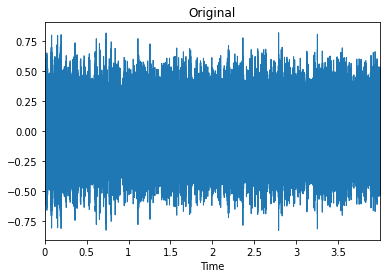

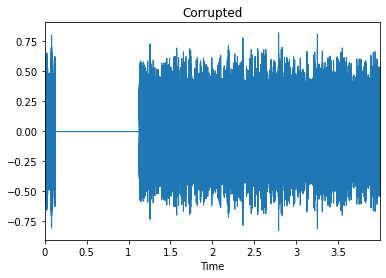

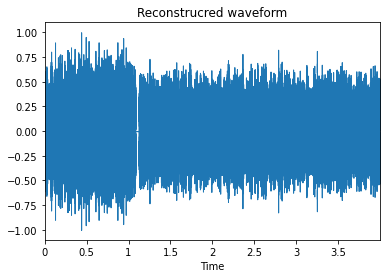


**************************************************
171 [D loss: 0.000000, acc: 100.00%] [G loss: 783.280945, mse: 783.992798]
172 [D loss: 0.000000, acc: 100.00%] [G loss: 1316.200562, mse: 1317.446167]
173 [D loss: 0.000000, acc: 100.00%] [G loss: 1193.290039, mse: 1194.419189]
174 [D loss: 0.000000, acc: 100.00%] [G loss: 1173.140137, mse: 1174.248779]
175 [D loss: 0.000000, acc: 100.00%] [G loss: 1148.559326, mse: 1149.639648]
176 [D loss: 0.000000, acc: 100.00%] [G loss: 1249.955322, mse: 1251.137573]
177 [D loss: 0.000000, acc: 100.00%] [G loss: 1205.333130, mse: 1206.473511]
178 [D loss: 0.000000, acc: 100.00%] [G loss: 1431.009277, mse: 1432.377930]
179 [D loss: 0.000000, acc: 100.00%] [G loss: 1098.124268, mse: 1099.157959]
180 [D loss: 0.000000, acc: 100.00%] [G loss: 1532.749023, mse: 1534.221313]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


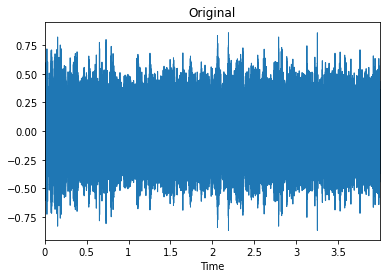

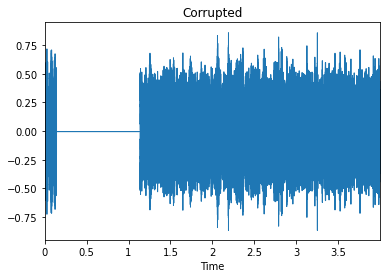

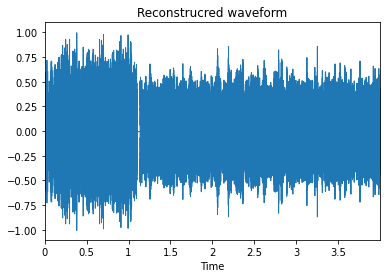


**************************************************


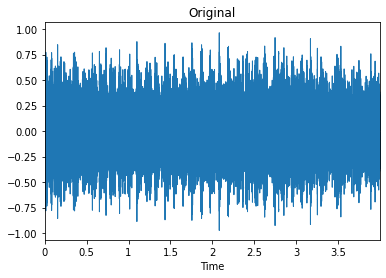

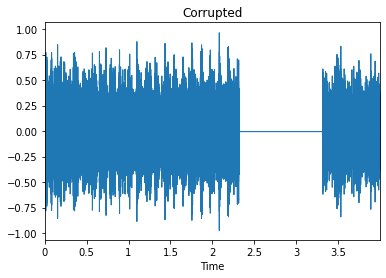

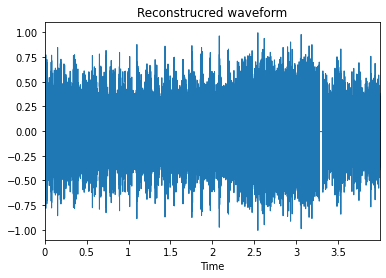


**************************************************


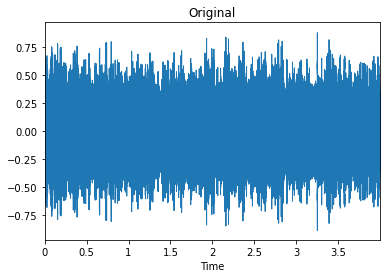

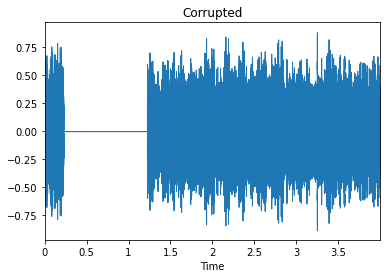

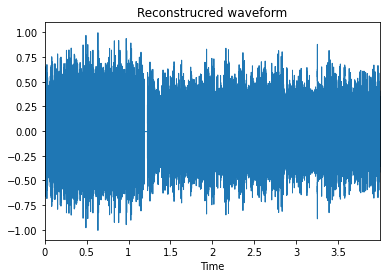


**************************************************
181 [D loss: 0.000000, acc: 100.00%] [G loss: 1229.200562, mse: 1230.368774]
182 [D loss: 0.000000, acc: 100.00%] [G loss: 1343.965820, mse: 1345.248291]
183 [D loss: 0.000000, acc: 100.00%] [G loss: 1354.526123, mse: 1355.820068]
184 [D loss: 0.000000, acc: 100.00%] [G loss: 1561.891846, mse: 1563.393921]
185 [D loss: 0.000000, acc: 100.00%] [G loss: 1119.312744, mse: 1120.365601]
186 [D loss: 0.000000, acc: 100.00%] [G loss: 1642.102295, mse: 1643.680542]
187 [D loss: 0.000000, acc: 100.00%] [G loss: 1198.371338, mse: 1199.502441]
188 [D loss: 0.000000, acc: 100.00%] [G loss: 1387.709595, mse: 1389.029785]
189 [D loss: 0.000000, acc: 100.00%] [G loss: 1109.348145, mse: 1110.387939]
190 [D loss: 0.000000, acc: 100.00%] [G loss: 1214.719238, mse: 1215.865601]
float32
float32
GEN MISSING SHAPE:  (6, 128, 16, 1)


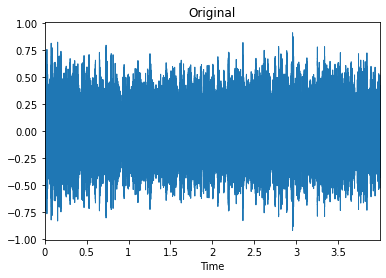

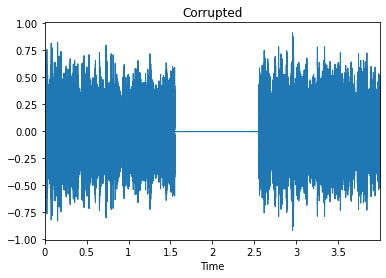

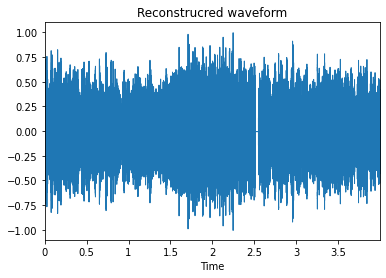


**************************************************


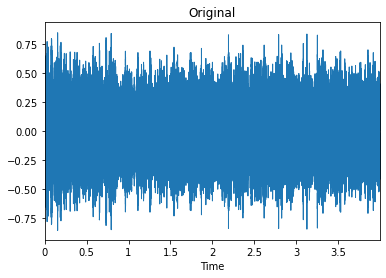

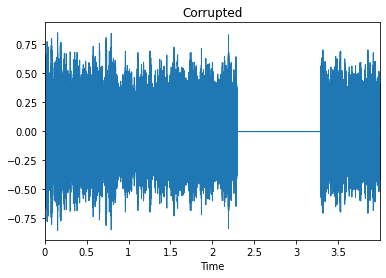

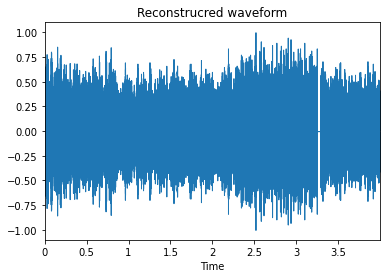


**************************************************


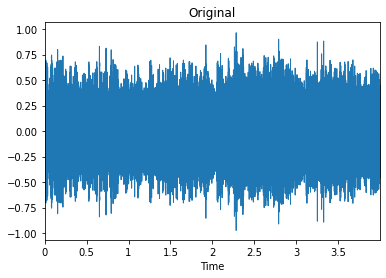

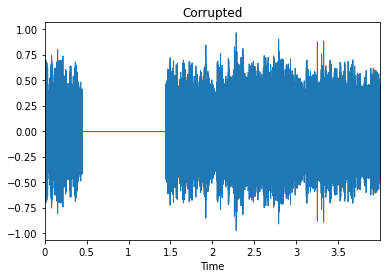

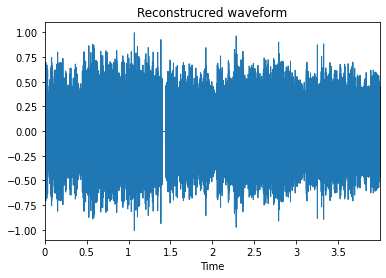


**************************************************
191 [D loss: 0.000000, acc: 100.00%] [G loss: 2173.024414, mse: 2175.136719]
192 [D loss: 0.000000, acc: 100.00%] [G loss: 1372.492676, mse: 1373.802490]
193 [D loss: 0.000000, acc: 100.00%] [G loss: 967.409546, mse: 968.311279]
194 [D loss: 0.000000, acc: 100.00%] [G loss: 1332.178467, mse: 1333.445312]
195 [D loss: 0.000000, acc: 100.00%] [G loss: 1331.372559, mse: 1332.637695]
196 [D loss: 0.000000, acc: 100.00%] [G loss: 1532.942993, mse: 1534.409424]
197 [D loss: 0.000000, acc: 100.00%] [G loss: 1116.049316, mse: 1117.096313]
198 [D loss: 0.000000, acc: 100.00%] [G loss: 1857.183350, mse: 1858.979980]
199 [D loss: 0.000000, acc: 100.00%] [G loss: 1782.068848, mse: 1783.791260]
Shape save images:  (8732, 128, 16, 1)


In [ ]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np

class ContextEncoder():
    def __init__(self):
        # immagini di 128x63 (melspectrogram) e corruzione di 128x16 (corrispondente ad una corruzione di 8000 sulla waveform); numero di canali: 1 
        self.img_rows = 128
        self.img_cols = 63
        self.mask_height = 128
        self.mask_width = 16
        self.channels = 1
        self.num_classes = 2
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.channels)
        self.sr=8000

        optimizer = Adam(0.02, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates the missing
        # part of the image
        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)
        print(gen_missing.shape)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator(gen_missing)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(masked_img , [gen_missing, valid])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        # Encoder
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(512, kernel_size=1, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        # Decoder
        model.add(UpSampling2D(size=(4,2)))
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D(size=(4,2)))
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation('tanh'))

        model.summary()

        masked_img = Input(shape=self.img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.missing_shape)
        validity = model(img)

        return Model(img, validity)

    def mask_randomly(self, imgs_original):
        imgs = copy.deepcopy(imgs_original)
        
        # corrompo la waveform 
        corruption_length=8000
        masked_imgs = []
        missing_parts = np.empty((imgs.shape[0], corruption_length, self.channels))
        masked_imgs_mel = []
        missing_parts_mel = []
        x1 = []
        x2 = []
        for i, sample in enumerate(imgs):
          rand1 = random.randint(0, int(len(sample)/1.3)) #24000 
          zeros = np.zeros(shape=sample[rand1:].shape)
          if (sample[rand1:]==zeros).all() == True or sample[rand1:rand1+corruption_length, :].shape[0]<8000:
              rand1 = random.randint(0, int(len(sample)/6)) # 5000 
              missing_parts[i]=sample[rand1:rand1+corruption_length, :]
          else:
              missing_parts[i]=sample[rand1:rand1+corruption_length, :]
          sample[rand1:rand1+corruption_length] = 0 
          masked_imgs.append(sample)
          # converto la waveform in mel spectrogram
          masked_imgs_mel.append(librosa.feature.melspectrogram(y=sample.reshape(-1), sr=self.sr))
          # converto il frammento corrotto in mel spectrogram
          missing_parts_mel.append(librosa.feature.melspectrogram(y=missing_parts[i].reshape(-1), sr=self.sr))
          x1.append(rand1)
          x2.append(rand1+corruption_length)

        return np.array(masked_imgs), missing_parts, np.array(masked_imgs_mel), np.array(missing_parts_mel), np.array(x1), np.array(x2)

    '''
    # funzione per riadattare le immagini alla rete
    def resize_and_reshape(self, masked_imgs, missing_parts, shape_masked, shape_missing):
      masked_imgs_reshaped = []
      missing_parts_reshaped = []
      for i in range(len(masked_imgs)):
        masked_imgs_reshaped.append(masked_imgs[i].reshape(shape_masked))
        masked_imgs_reshaped[i]=tf.image.resize(masked_imgs_reshaped[i], [self.img_rows, self.img_cols]) 

        missing_parts_reshaped.append(missing_parts[i].reshape(shape_missing))
        missing_parts_reshaped[i]=tf.image.resize(missing_parts_reshaped[i], [self.mask_height, self.mask_width]) 
      return np.array(masked_imgs_reshaped), np.array(missing_parts_reshaped)
    '''

    def train(self, epochs, batch_size=128, sample_interval=50):

        X_train, X_test, y_train, y_test = train_test_split(data, labels.values, test_size=0.2, shuffle=False)

        # Extract classes (at the beginning it was only two classes)
        X0 = X_train[(y_train == 0).flatten()]
        X1 = X_train[(y_train == 1).flatten()]
        X2 = X_train[(y_train == 2).flatten()]
        X3 = X_train[(y_train == 3).flatten()]
        X4 = X_train[(y_train == 4).flatten()]
        X5 = X_train[(y_train == 5).flatten()]
        X6 = X_train[(y_train == 6).flatten()]
        X7 = X_train[(y_train == 7).flatten()]
        X8 = X_train[(y_train == 8).flatten()]
        X9 = X_train[(y_train == 9).flatten()]

        # Stack arrays in sequence vertically (row wise)
        X_train = np.vstack((X0, X1, X2, X3, X4, X5, X6, X7, X8, X9))

        from sklearn.preprocessing import MinMaxScaler
        self.mms = MinMaxScaler(feature_range=(-1,1))
        from sklearn.preprocessing import MaxAbsScaler
        self.mas = MaxAbsScaler()

        # Rescale -1 to 1
        X_train = self.mms.fit_transform(X_train.reshape(X_train.shape[0], 32000))
        X_train = X_train.reshape(X_train.shape[0], 32000, 1)
        #y_train = y_train.reshape(-1, 1)
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
          # ---------------------
          #  Train Discriminator
          # ---------------------

          # Select a random batch of images
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]

          # both referred to mel
          _, _, masked_imgs, missing_parts, _, _= self.mask_randomly(imgs)
          #print("Missing parts shape: ", missing_parts.shape, np.max(missing_parts[0]), np.min(missing_parts[0]))
         
          # masked_imgs.shape = (64, 128, 63) dimensione mel spectrogram associato a waveform 32000,1 (batch_size, row, cols)
          # missing_parts.shape = (64, 128, 16) dimensione mel spetrogram associato a frammento corroto 8000,1 (batch_size, row, cols)
          
          #masked_imgs, missing_parts = self.resize_and_reshape(masked_imgs, missing_parts, (128, 63, 1), (128, 16, 1))

          # Generate a batch of new images
          gen_missing = self.generator.predict(masked_imgs)
          original_shape = gen_missing.shape
          gen_missing = self.mas.fit_transform(gen_missing.reshape(gen_missing.shape[0], -1)).reshape(original_shape)
          #librosa.display.waveplot(librosa.feature.inverse.mel_to_audio(missing_parts[1]))
          #plt.title("Corrupted part fed to the net ")
          #plt.show()

          # Train the discriminator          
          d_loss_real = self.discriminator.train_on_batch(missing_parts, valid)
          d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

          # ---------------------
          #  Train Generator
          # ---------------------

          g_loss = self.combined.train_on_batch(masked_imgs, [missing_parts, valid])

          # Plot the progress
          print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

          # If at save interval => save generated image samples
          if epoch % sample_interval == 0:
              idx = np.random.randint(0, X_train.shape[0], 6)
              imgs = X_train[idx]
              self.sample_images(epoch, imgs)
              #self.save_images(imgs)

    # bozza per salvare dataset ricostruito
    def save_images(self, imgs):
       reconstructed_audio = []

       masked_imgs, missing_parts, masked_imgs_mel, missing_parts_mel, x1, x2 = self.mask_randomly(imgs)
       gen_missing = self.generator.predict(masked_imgs_mel)
       print("Shape save images: ",gen_missing[:].shape) # (8732, 128, 16, 1)
       for i in range(10):
         tmp = gen_missing[i].reshape(128,16)
         mel_to_wave_missing = librosa.feature.inverse.mel_to_audio(tmp, sr=self.sr)
         mel_to_wave_missing = self.mas.fit_transform(mel_to_wave_missing.reshape(-1, 1))
         zeros = np.zeros((8000,1)) 
         zeros[:mel_to_wave_missing.shape[0], :] = mel_to_wave_missing
         recon_wave = copy.deepcopy(masked_imgs[i, :, :])
         recon_wave[x1[i]:x2[i], :] = zeros

       reconstructed_audio.append(recon_wave)
       savez_compressed("/content/gdrive/MyDrive/UrbanSound8K/dati/reconstructed_8kHz.npz", reconstructed_audio)

    def sample_images(self, epoch, imgs):
        r, c = 3, 6        

        masked_imgs, missing_parts, masked_imgs_mel, missing_parts_mel, x1, x2 = self.mask_randomly(imgs) #x1.shape = (#images, 1)

        # Prima del resize and reshape: masked_imgs_mel.shape (6, 128, 63), missing_parts_mel.shape (6, 128, 16)
        # masked_imgs_mel, missing_parts_mel = self.resize_and_reshape(masked_imgs_mel, missing_parts_mel, (128, 63, 1), (128, 16, 1))
        # Dopo il resize and reshape: masked_imgs_mel.shape (6, 128, 63, 1), missing_parts_mel.shape (6, 128, 16, 1)
       
        # parte ricostruita del mel spectrogram (8x8)
        gen_missing = self.generator.predict(masked_imgs_mel)
        print(gen_missing.dtype) # float32 (?)
        print(gen_missing[1].dtype) # float32 (?)       
        
        # normalizzare il valore gen_missing dividendo per il massimo del valore assoluto 
        print("GEN MISSING SHAPE: ", gen_missing.shape)

        '''
        imgs = 0.5 * imgs + 0.5
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5
        '''
      
        for i in range(3):
          
          #waveform originale
          librosa.display.waveplot(imgs[i, :, :].reshape(-1), sr=8000)
          plt.title("Original")
          plt.show()

          #waveform corrotta
          librosa.display.waveplot(masked_imgs[i, :, :].reshape(-1), sr=8000)
          plt.title("Corrupted")
          plt.show()

          tmp = gen_missing[i].reshape(128,16)
                           
          #print("Max value reconstructed piece: ", np.max(tmp))
          #print("Min value reconstructed piece: ", np.min(tmp))         
          #print("Gen missing reshape, expected (128,16)", tmp.shape)
          mel_to_wave_missing = librosa.feature.inverse.mel_to_audio(tmp, sr=self.sr)
          mel_to_wave_missing = self.mas.fit_transform(mel_to_wave_missing.reshape(-1, 1)) 
          #print("Recon wave shape, expected (circa 8000): ", mel_to_wave_missing.shape) # (circa 8000,1)
          zeros = np.zeros((8000,1)) 
          zeros[:mel_to_wave_missing.shape[0], :] = mel_to_wave_missing    
          # mel to wave con padding per colmare gli 8000     
          #print("Corrupted fragment shape wave, expected (8000, ):", zeros.shape) # (8000,)
          recon_wave = copy.deepcopy(masked_imgs[i, :, :])
          recon_wave[x1[i]:x2[i], :] = zeros
          #print("Recon wave shape, expected (32000,1)", recon_wave.shape)
          # wave ricostruita (32000, 1)
          # recon_wave = self.mas.fit_transform(recon_wave) 
          librosa.display.waveplot(recon_wave.reshape(-1), sr=self.sr)
          plt.title("Reconstrucred waveform")
          plt.show()
          #reconstructed = masked_imgs[i, :, :]
          print("")
          print("*"*50)
          '''
          librosa.display.waveplot(mel_to_wave_missing.reshape(-1), sr=self.sr)
          plt.title("Missing piece reconstructed")
          plt.show()
          '''

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

if __name__ == '__main__':
    context_encoder = ContextEncoder()
    context_encoder.train(epochs=200, batch_size=64, sample_interval=10)
    context_encoder.save_images(data)